### Unstructured data collection from STJobs and analysis 

In this project, a sampling of job postings from the STJobs website was collected and cleaned. A preliminary analysis was conducted on the data to find the best paying jobs, the jobs requiring the least experience and the most common skills required in each industry 

Data source: www.stjobs.com


In [ ]:
### COLLECT DATA FROM STJOBS

import requests
from bs4 import BeautifulSoup
import csv
import unicodecsv as csv


def getsoup(url):
    
    content = requests.get(url).text
    soup = BeautifulSoup(content, 'html.parser')

    return soup

def get_data(searchresultpage_url, industry):
    
    soup = getsoup(searchresultpage_url)
    
    a_list = soup.find_all('a',{'class':"view_companyprofile"})

    base_url = "http://www.stjobs.sg/"
    
    all_job_urls = []
    
    # get individual urls for each job posting in the search result page
    for atag in a_list:
        job_url = base_url + atag.get('href')
        all_job_urls.append(job_url)
    
    alljobs_inpage = []
    
    # get job posting details from individual urls
    for job_url in all_job_urls:
        
        jobdetail = {}
        jobdetail['url'] = job_url
        jobdetail['industry'] = industry
        soup = getsoup(job_url) 
        
        titlebox = soup.find("div",{"class":"title-page"})
        if titlebox:
            jobdetail['jobtitle'] = titlebox.find("h3").text
            company_details = titlebox.find("h4").text.split("Posted On :")
            jobdetail['company'] = company_details[0].strip()
            
            jobdetail['date_posted'] = company_details[1].strip()
    
        companyadd = soup.find("ul",{"class":"who"})
        if companyadd:
            try:
                jobdetail['address'] = companyadd.find_all("li")[1].text.strip()
            except:
                jobdetail['address'] = "Not Available"
    
        jobsummary = soup.find("div",{"class":"job-summary"})
        if jobsummary:
            allitems = jobsummary.find_all("li")
 
        # converting the job detail fields to a dictionary, retaining the fieldnames on the website as dictionary keys 
            for listitem in allitems:
                temp = listitem.text.split(":")
            
                jobdetail[temp[0].strip().replace(" ","")] = temp[1].strip()
 
        alljobs_inpage.append(jobdetail)
    
    return alljobs_inpage
   

baseurl = "http://www.stjobs.sg/singapore-jobs/"

industry_list = ["science-technology-job",
            "accounting-audit-job",
            "energy-natural-resources-oil-gas-power-services-job"]

header =  [u'industry', u'jobtitle', u'company', u'Salary',u'YearsofExperience',u'FieldofStudy',u'Skills',
           u'Min.EducationLevel',u'Location',u'date_posted',u'WorkType', u'address', u'url']

f = open("joblist.csv","w")
csv_dict_writer = csv.DictWriter(f, fieldnames = header)
csv_dict_writer.writeheader()
f.close()


for industry in industry_list:
    searchresultlist_urls=[]

    # create list of search result urls for each industry. The first 6 pages / urls are used in this project
    for i in range(1,7):
        url = baseurl + industry +"/page"+str(i)
        searchresultlist_urls.append(url) 
    
    # get job details for postings in each search result url and write to file
    for url in searchresultlist_urls:
        job_details = get_data(url, industry)
        
        f = open("joblist.csv","a")
        csv_dict_writer = csv.DictWriter(f, fieldnames = header)
        csv_dict_writer.writerows(job_details)
        f.close()

In [25]:
### DATA TRANSFORMATION

import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("joblist.csv")

# get min and max salary from salary range
df['min_sal']=  df['Salary'][df['Salary'].str.contains("-")].apply(lambda x: str(x).split('-')[0])
df['max_sal']=  df['Salary'][df['Salary'].str.contains("-")].apply(lambda x: str(x).split('-')[1])

# reduce jobtitle length for brevity, for charts
df['shortitle'] = df['jobtitle'].apply(lambda x: str(x)[0:50])
df[['max_sal','min_sal']] = df[['max_sal','min_sal']].apply(lambda x: pd.to_numeric(x))

# jobs that pay well relative to years of experience required
df['sal_norm_exp'] = df['max_sal']/df['YearsofExperience']




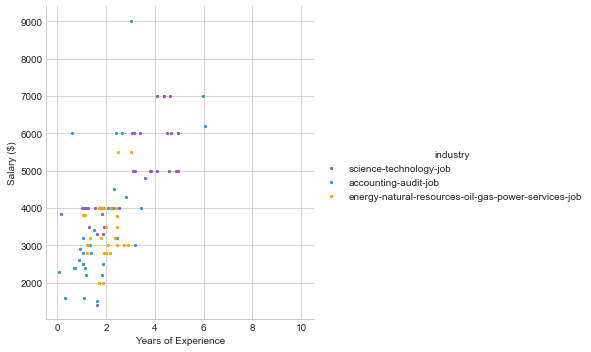

In [26]:
### SALARY VS YEARS OF EXPERIENCE

import seaborn as sns


flatui = ["#9b59b6", "#3498db", "orange"]
sns.set_palette(flatui)
fig = sns.lmplot( x='YearsofExperience', y='max_sal', data=df, fit_reg=False, hue='industry', 
           legend_out=True, scatter_kws={"alpha":1,"s":5},x_jitter=1,y_jitter=1 )

plt.ylabel('Salary ($)')
plt.xlabel('Years of Experience')
plt.show()

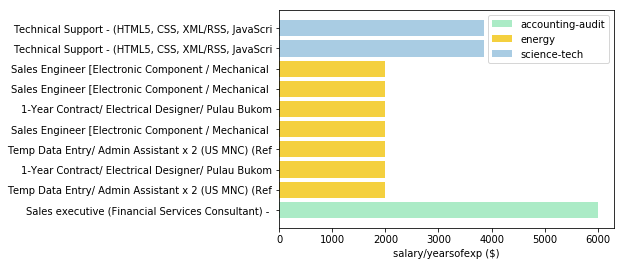

In [7]:
# best postings: high salary and least exp

industry_group_data = df.groupby('industry')

#Find the best posting in each industry (best salary and least experience)
def find_best_salary(df):
    value = df['sal_norm_exp'].max()
    return df[df['sal_norm_exp']==value]

def least_exp(df):
    value = df['YearsofExperience'].min()
    return df[df['YearsofExperience']==value]


bestsalary_norm_byexp = industry_group_data.apply(find_best_salary)

bars1 = bestsalary_norm_byexp['sal_norm_exp'][bestsalary_norm_byexp['industry']=="accounting-audit-job"]
bars2 = bestsalary_norm_byexp['sal_norm_exp'][bestsalary_norm_byexp['industry']=="energy-natural-resources-oil-gas-power-services-job"]
bars3 = bestsalary_norm_byexp['sal_norm_exp'][bestsalary_norm_byexp['industry']=="science-technology-job"]

labels1 = bestsalary_norm_byexp['shortitle'][bestsalary_norm_byexp['industry']=="accounting-audit-job"].tolist()
labels2 = bestsalary_norm_byexp['shortitle'][bestsalary_norm_byexp['industry']=="energy-natural-resources-oil-gas-power-services-job"].tolist()
labels3 = bestsalary_norm_byexp['shortitle'][bestsalary_norm_byexp['industry']=="science-technology-job"].tolist()

ylabels = labels1 + labels2 + labels3

r1 = np.arange(1,len(bars1)+1)
r2 = np.arange(len(bars1)+1,len(bars2)+len(bars1)+1)
r3 = np.arange(len(bars2)+len(bars1)+1,len(bars3)+len(bars2)+len(bars1)+1)
r4 = np.arange(1, len(bars3)+len(bars2)+len(bars1)+1)

plt.barh(r1, bars1, color = '#ABEBC6', label='accounting-audit')
plt.barh(r2, bars2, color = '#F4D03F', label= 'energy' )
plt.barh(r3, bars3, color = '#A9CCE3', label= 'science-tech')



plt.legend()
plt.xlabel('salary/yearsofexp ($)')

ax = plt.axes()

plt.yticks(r4, ylabels)

plt.show()



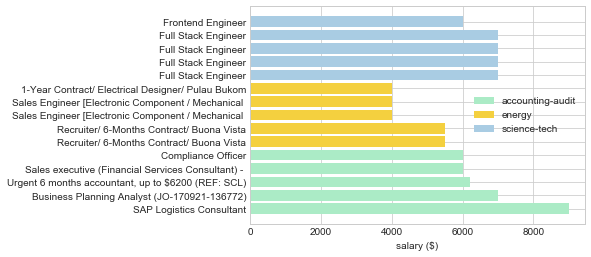

In [27]:
# top 5 salaries for each industry

import sys  

reload(sys)  
sys.setdefaultencoding('utf8')

top5salaries = industry_group_data.apply(lambda x : x.sort_values(['max_sal'], ascending=False).head(5))

bars_aa = top5salaries[top5salaries['industry']=="accounting-audit-job"]['max_sal']
bars_e = top5salaries[top5salaries['industry']=="energy-natural-resources-oil-gas-power-services-job"]['max_sal']
bars_st = top5salaries[top5salaries['industry']=="science-technology-job"]['max_sal']

r1 = np.arange(1,6)
r2 = np.arange(6,11)
r3 = np.arange(11,16)
r4 = np.arange(1,16)

labels1 = top5salaries['shortitle'][top5salaries['industry']=="accounting-audit-job"].tolist()
labels2 = top5salaries['shortitle'][top5salaries['industry']=="energy-natural-resources-oil-gas-power-services-job"].tolist()
labels3 = top5salaries['shortitle'][top5salaries['industry']=="science-technology-job"].tolist()

ylabels = labels1 + labels2 + labels3
#print(len(xlabels))
#print(len(r4))

plt.barh(r1, bars_aa, color = '#ABEBC6', label='accounting-audit')
plt.barh(r2, bars_e, color = '#F4D03F', label= 'energy' )
plt.barh(r3, bars_st, color = '#A9CCE3', label= 'science-tech')


plt.legend()
plt.xlabel('salary ($)')

ax = plt.axes()
plt.yticks(r4, ylabels)


plt.show()



There appear to be some repeated job postings by companies!

In [28]:
### MOST COMMON SKILLS
#from collections import Counter

def get_top_skills(df):
    
    df = df.dropna(subset = ['Skills'])
    df['Skills']= df['Skills'].astype(str)
    
    # cleaning up some similar skills
    df['Skills']= df['Skills'].apply(lambda x:x.replace("MS Office", "Microsoft Office"))
    df['Skills']= df['Skills'].apply(lambda x:x.replace("Excel macro", "Microsoft Office"))
    
    x = df['Skills'].apply(lambda x: pd.value_counts(x.split(","), dropna=True)).sum(axis = 0).sort_values(ascending=False).head(5)

    return x

test = industry_group_data.apply(get_top_skills)

counts = test.values
skills = test.index
skills = skills.tolist()

industry = []
updatedskill = []

updatedskill = pd.DataFrame(skills , columns=['industry','skill'])
counts = pd.DataFrame(counts, columns = ['count'])

## merge columns
toplot = pd.concat([updatedskill, counts], axis=1)
toplot

# to sort out the repeated Accounting entries

,industry,skill,count
0,accounting-audit-job,Microsoft Office,5.0
1,accounting-audit-job,Accounting,5.0
2,accounting-audit-job,MAS and Statutory reporting,2.0
3,accounting-audit-job,Accounting,2.0
4,accounting-audit-job,Good communication skills,2.0
5,energy-natural-resources-oil-gas-power-service...,Microsoft Office,15.0
6,energy-natural-resources-oil-gas-power-service...,Communications skills,6.0
7,energy-natural-resources-oil-gas-power-service...,Organisational skills,6.0
8,energy-natural-resources-oil-gas-power-service...,Time management,6.0
9,energy-natural-resources-oil-gas-power-service...,Interpersonal skills,6.0


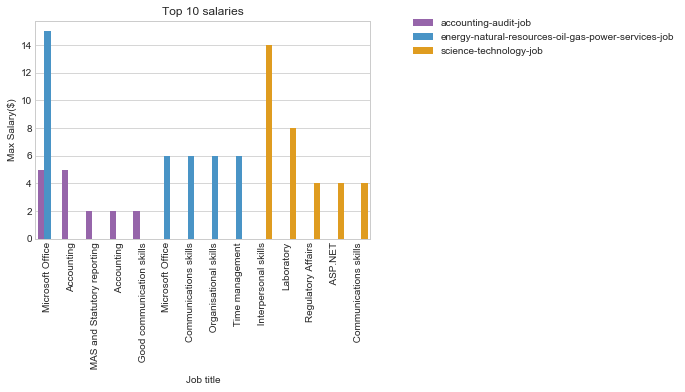

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

g = sns.barplot(x = 'skill',y = 'count', hue='industry', data=toplot)
ax = plt.subplot(111)
ax.legend(bbox_to_anchor=(1.1, 1.05))
#g.set_axis_labels("Max Salary($)", "Jobtitle")
plt.title("Top 10 salaries")
plt.ylabel("Max Salary($)")
plt.xlabel("Job title")
g.set_xticklabels(toplot['skill'],rotation = 90)
plt.show(g)